In [10]:
import operator
from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
import tavily

class SearchState(TypedDict):
    query: str
    basic_result: dict
    score: int
    status: str
    evaluation: str

tavily_client = tavily.TavilyClient("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")

def initialize(state: SearchState) -> SearchState:
    """Initialize the workflow and validate input."""
    print(f"Starting search for query: {state['query']}")
    return {
        "status": "initialized"
    }

def basic_search(state: SearchState) -> SearchState:
    """Perform a basic web search using Tavily."""
    try:
        print("\n === Performing Basic Web Search ===")
        response = tavily_client.search(
            query=state['query'],
            search_depth="basic",
            max_result=1
        )
        answer = response["results"][0]
        score = response["results"][0].get("score")
        
        return {
            "basic_result": answer,
            "score": score,
            "status": "search_completed"
        }
    except Exception as e:
        print(f"Error during search: {e}")
        return {
            "status": "error"
        }

def basic_search_display(state: SearchState) -> SearchState:
    """Display the results of the basic search."""
    try:
        print("\n ===== Basic Search Results =====")
        result = state['basic_result']
        print(f"Title: {result.get('title', 'N/A')}")
        print(f"URL: {result.get('url', 'N/A')}")
        print(f"Content Preview: {result.get('content', 'N/A')[:300]}")
        print(f"Score: {state['score']}")

        return {
            "status": "display_complete"
        }
    except Exception as e:
        print(f"Error during display: {e}")
        return {
            "status": "error"
        }

def evaluate_search(state: SearchState) -> SearchState:
    """Evaluate the quality of the search results."""
    try:
        score = state['score']*100
        evaluation = "Good" if score > 50 else "Poor"
        print(f"\n === Evaluation of Search Results ===")
        print(f"Evaluation: {evaluation}")

        return {
            "evaluation": evaluation,
            "status": "evaluation_complete"
        }
    except Exception as e:
        print(f"Error during evaluation: {e}")
        return {
            "status": "error"
        }

def router(state: SearchState) -> str:
    """Route to the next state based on the current status."""
    if state['status'] == 'initialized':
        return "basic_search"
    elif state['status'] == 'search_completed':
        return "basic_search_display"
    elif state['status'] == 'display_complete':
        return "evaluate_search"
    elif state['status'] == 'evaluation_complete':
        return END
    else:
        return END

# Building the state graph
builder = StateGraph(SearchState)
builder.add_node("initialize", initialize)
builder.add_node("basic_search", basic_search)
builder.add_node("basic_search_display", basic_search_display)
builder.add_node("evaluate_search", evaluate_search)
builder.add_edge(START, "initialize")
builder.add_edge("initialize", "basic_search")
builder.add_edge("basic_search", "basic_search_display")
builder.add_edge("basic_search_display", "evaluate_search")
builder.add_edge("evaluate_search", END)
graph = builder.compile()

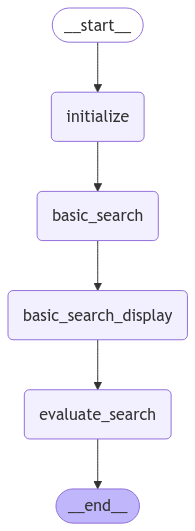

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
# Running the graph
if __name__ == "__main__":
    initial_state = {
        "query": "Who is the leading run scorer in ODI Cricket?",
        "basic_result": {},
        "score": 0,
        "status": "",
        "evaluation": ""
    }
    graph.invoke(initial_state)

Starting search for query: Who is the leading run scorer in ODI Cricket?

 === Performing Basic Web Search ===

 ===== Basic Search Results =====
Title: Top 10 Leading Run-Scorers In ODIs - CricTracker
URL: https://www.isportindia.com/record/top-10-leading-run-scorers-in-odis
Content Preview: Here's a list of the top 10 leading run-scorers in ODI cricket. 10. Rahul Dravid. Rahul Dravid, "The Wall," renowned for his defense, ranks 10th among ODI run-getters. In 344 matches, he scored 10,889 runs at an average of 39.16 and a strike rate of 71.23, including 12 centuries and 83 fifties, with
Score: 0.9363841

 === Evaluation of Search Results ===
Evaluation: Good
